# Abstract structure
class DiffusionModel:
    
    def __init__(self):
        
        self.betas = calculate_betas()
        self.alphas = 1 - self.betas

    def forward_diffusion(self, X_0, timestep):
        # Apply noise based on betas and alphas
        pass

    def reverse_diffusion(self, X_T):
        # Iteratively denoise starting from noise
        pass

    def train(self, data):
        # Train model to predict noise
        pass

if __name__ == "__main__":
    
    model = DiffusionModel()
    model.train(training_data)
    generated_images = model.reverse_diffusion(noise)

In [4]:
# Using torch
import torch
import torch.nn as nn
from torchvision import transforms, datasets

import numpy as np
from torch.utils.data import DataLoader

In [5]:
# Define the diffusion model settings
class DiffusionSettings:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02): # From Paper
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps) # Can be non-linear
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

In [66]:
# Main forward / backward algorithm
def forward_diffusion(x0, t, settings):
    noise = torch.randn_like(x0) # Needs to check
    # TODO
    sqrt_alphas_cumprod = settings.sqrt_alphas_cumprod[t].unsqueeze(1).unsqueeze(2).unsqueeze(3)
    sqrt_one_minus_alphas_cumprod = settings.sqrt_one_minus_alphas_cumprod[t].unsqueeze(1).unsqueeze(2).unsqueeze(3)
    xt = settings.sqrt_alphas_cumprod[t] * x0 + settings.sqrt_one_minus_alphas_cumprod[t] * noise
    return xt, noise

# Reverse diffusion
def reverse_diffusion(model, settings, device):
    x_t = torch.randn((1, 1, 32, 32), device=device)
    # tensor filled with random numbers from N(0, 1), just the epsilon in my note
    for t in reversed(range(0, settings.num_timesteps)): # num_timesteps should be large in general
        noise_pred = model(x_t)
        if t == 0:
            x_t = x_t - settings.sqrt_one_minus_alphas_cumprod[t] * noise_pred
        else:
            x_t = (x_t - settings.sqrt_one_minus_alphas_cumprod[t] * noise_pred) / settings.sqrt_alphas_cumprod[t]
    return x_t

In [75]:
import torch.nn as nn

# Use a simple U-Net like in the paper, could design our own though
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # self.conv2 = nn.Conv2d(16, 3, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # print("Input shape:", x.shape)
        x = self.relu(self.conv1(x))
        #print("After conv1 shape:", x.shape)
        x = self.conv2(x)
        # print("After conv2 shape:", x.shape)
        return x

In [85]:
def train(model, settings, dataloader, device, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam is changable
    model.train()

    for epoch in range(epochs):
        for images, _ in dataloader: # TODO: Debug
            images = images.to(device)
            t = torch.randint(0, settings.num_timesteps, (images.size(0),), device=device)
            xt, noise = forward_diffusion(images, t, settings)
            
            noise_pred = model(xt)
            loss = torch.mean((noise_pred - noise) ** 2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    return model

In [86]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Deal with the channel problem??
    transforms.Resize((32, 32)),  # Resize to the desired size
    transforms.ToTensor()
])

In [78]:
# Debugging
model = UNet()
device = torch.device("cpu")
model.to(device)

# Gray image 32*32
dummy_input = torch.randn(1, 1, 32, 32, device=device)

# Forward pass
output = model(dummy_input)
print(output.shape)  # Correct

torch.Size([1, 1, 32, 32])


In [87]:
dataset = datasets.ImageFolder(root="/Users/xinmingshen_1/Desktop/cat-50", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

device = torch.device("cpu")
settings = DiffusionSettings()
model = UNet().to(device)

# Train
model = train(model, settings, dataloader, device)
# Input shape: torch.Size([32, 3, 32, 32])
# After conv1 shape: torch.Size([32, 16, 32, 32])
# After conv2 shape: torch.Size([32, 3, 32, 32])

# Grayscale debug
# Input shape: torch.Size([32, 1, 32, 32])
# After conv1 shape: torch.Size([32, 16, 32, 32])
# After conv2 shape: torch.Size([32, 1, 32, 32])

Epoch 1, Loss: 0.341324120759964
Epoch 2, Loss: 0.062164559960365295
Epoch 3, Loss: 0.05903550982475281
Epoch 4, Loss: 0.057791560888290405
Epoch 5, Loss: 0.04939177632331848
Epoch 6, Loss: 0.4735652804374695
Epoch 7, Loss: 0.6263924837112427
Epoch 8, Loss: 0.24130511283874512
Epoch 9, Loss: 0.050876226276159286
Epoch 10, Loss: 0.03684954717755318
Epoch 11, Loss: 0.03832477331161499
Epoch 12, Loss: 0.04775834083557129
Epoch 13, Loss: 0.05073809251189232
Epoch 14, Loss: 0.0361197292804718
Epoch 15, Loss: 0.03311845660209656
Epoch 16, Loss: 0.032539110630750656
Epoch 17, Loss: 0.03594784438610077
Epoch 18, Loss: 0.042582083493471146
Epoch 19, Loss: 0.04988117516040802
Epoch 20, Loss: 0.029998499900102615


In [74]:
dataset = datasets.ImageFolder(root="/Users/xinmingshen_1/Desktop/cat-50", transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

device = torch.device("cpu")
settings = DiffusionSettings()
model = UNet().to(device)

# Train
model = train(model, settings, dataloader, device)

Input shape: torch.Size([1, 1, 32, 32])
After conv1 shape: torch.Size([1, 16, 32, 32])
After conv2 shape: torch.Size([1, 1, 32, 32])
Input shape: torch.Size([1, 1, 32, 32])
After conv1 shape: torch.Size([1, 16, 32, 32])
After conv2 shape: torch.Size([1, 1, 32, 32])
Input shape: torch.Size([1, 1, 32, 32])
After conv1 shape: torch.Size([1, 16, 32, 32])
After conv2 shape: torch.Size([1, 1, 32, 32])
Input shape: torch.Size([1, 1, 32, 32])
After conv1 shape: torch.Size([1, 16, 32, 32])
After conv2 shape: torch.Size([1, 1, 32, 32])
Input shape: torch.Size([1, 1, 32, 32])
After conv1 shape: torch.Size([1, 16, 32, 32])
After conv2 shape: torch.Size([1, 1, 32, 32])
Input shape: torch.Size([1, 1, 32, 32])
After conv1 shape: torch.Size([1, 16, 32, 32])
After conv2 shape: torch.Size([1, 1, 32, 32])
Input shape: torch.Size([1, 1, 32, 32])
After conv1 shape: torch.Size([1, 16, 32, 32])
After conv2 shape: torch.Size([1, 1, 32, 32])
Input shape: torch.Size([1, 1, 32, 32])
After conv1 shape: torch.Size

In [81]:
import matplotlib.pyplot as plt

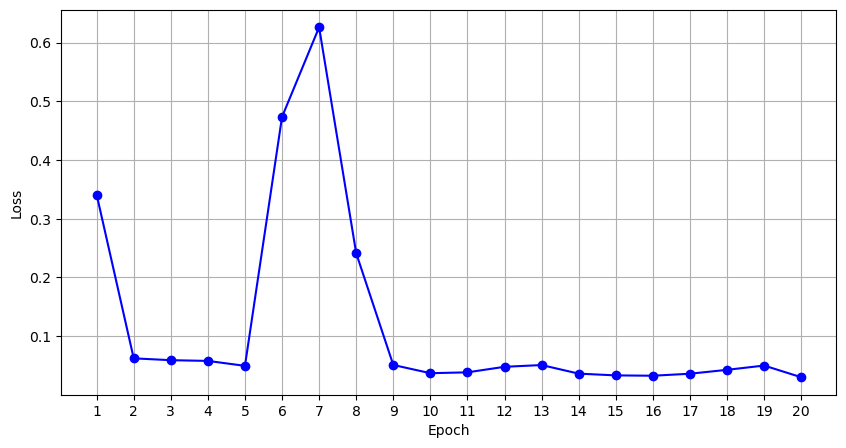

In [90]:
# Scared to change ↑
loss_values = [
    0.341324120759964, 0.062164559960365295, 0.05903550982475281,
    0.057791560888290405, 0.04939177632331848, 0.4735652804374695,
    0.6263924837112427, 0.24130511283874512, 0.050876226276159286,
    0.03684954717755318, 0.03832477331161499, 0.04775834083557129,
    0.05073809251189232, 0.0361197292804718, 0.03311845660209656,
    0.032539110630750656, 0.03594784438610077, 0.042582083493471146,
    0.04988117516040802, 0.029998499900102615
]
epochs = range(1, 21) 

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs) 
plt.show()